# Drought Analysis at State Scale

This code was created to calculate the slope and perform our drought analysis on the statewide scale using all available wells.

To run this code, you need to follow all of the DataPreprocessing instructions.

Total time to run on my machine: Less than 5 minutes

In [1]:
# Packages and paths

import os
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import sys

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Local paths
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
figurepath = '../../Figures/Local'

In [2]:
# ==== Reading in the data ====
# Importing GRACE analyses
filepath = filepath = outputpath+'/grace_stateavg_yearly.csv'
grace_yearly = pd.read_csv(filepath, index_col=0)
grace_yearly = grace_yearly[:-1]
print("GRACE data loaded.")

# Read in the annual time series database
filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated.csv'
filepath = os.path.join(outputpath, filename_ts)
annual_db = pd.read_csv(filepath, header=1, index_col=0)
print("Well data loaded.")

annual_db = annual_db[1:168102]
annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2 = annual_db2.set_index('Combo_ID')
annual_db2.head()
print("Well data formatted.")

# Read in the drought indices

#  Input the date you downloaded the drought files
date_downloaded = "06102024"

drought_indices = pd.read_csv(f'{inputpath}/Yearly_DroughtIndices_updated{date_downloaded}.csv')
drought_indices = drought_indices.set_index('In_year')
print("Drought data loaded and formatted.")

GRACE data loaded.
Well data loaded.
Well data formatted.
Drought data loaded and formatted.


Creating Colors

In [12]:
# %% Creating colors

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# grace_color = '#A92B2A'
# grace_color = "#858585"
grace_color = "#7030A0"
# az_wells_color = '#1D4E77'
az_wells_color = 'black'

# Drought Colors
drought_color = "#D0CECE" #'#ffa6b8'
wet_color = '#b8d3f2'

Establishing Drought Years

In [5]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]
        ,7:[2021]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018], 7: [2021]}


In [6]:
yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]

In [7]:
drought_indices

PDSI  wet  dry      PHDI
In_year                              
1975    -1.415833    3   -3 -1.415833
1976    -0.960000    3   -3 -0.881667
1977    -1.915000    3   -3 -1.915000
1978     2.999167    3   -3  2.831667
1979     5.378333    3   -3  5.378333
1980     1.710000    3   -3  3.660833
1981    -2.196667    3   -3 -2.196667
1982     0.982500    3   -3  0.443333
1983     4.949167    3   -3  4.949167
1984     0.318333    3   -3  1.910833
1985     3.087500    3   -3  3.381667
1986    -0.241667    3   -3  0.530000
1987     0.290833    3   -3  0.568333
1988     0.209167    3   -3  0.665000
1989    -3.215833    3   -3 -3.215833
1990    -1.346667    3   -3 -2.733333
1991     0.530833    3   -3  0.553333
1992     3.444167    3   -3  3.444167
1993     3.325000    3   -3  5.637500
1994    -0.838333    3   -3 -0.409167
1995     0.631667    3   -3  1.550000
1996    -4.137500    3   -3 -4.137500
1997    -1.864167    3   -3 -3.149167
1998     1.368333    3   -3  2.311667
1999    -1.272500    3   -3 -1.407500
2000    -2.535000    3   -3 -3.546667
2001    -0.101667    3   -3 -0.806667
2002    -4.600000    3   -3 -4.600000
2003    -3.618333    3   -3 -3.618333
2004    -2.030833    3   -3 -3.150000
2005     1.653333    3   -3  3.544167
2006    -3.385000    3   -3 -3.385000
2007    -3.930833    3   -3 -3.930833
2008    -1.469167    3   -3 -1.469167
2009    -2.694167    3   -3 -3.035000
2010     0.865000    3   -3  0.514167
2011    -2.496667    3   -3 -2.496667
2012    -3.564167    3   -3 -3.564167
2013    -2.672500    3   -3 -2.672500
2014    -3.291667    3   -3 -3.291667
2015    -0.597500    3   -3 -1.525833
2016    -2.055833    3   -3 -2.055833
2017    -1.717500    3   -3 -1.717500
2018    -3.342500    3   -3 -4.258333
2019     0.552500    3   -3 -0.132500
2020    -0.966667    3   -3 -0.812500
2021    -3.826667    3   -3 -3.826667
2022    -1.569167    3   -3 -3.195000
2023     0.120000    3   -3  0.114167
2024    -1.260000    3   -3 -1.260000

Create an initial timeseries plot

         State Average DTW
slope         1.658487e+00
int          -3.123594e+03
rsq           7.211877e-01
p_val         2.387366e-14
std_err       1.520425e-01
mean          1.908936e+02
var           7.319624e+02
sum           9.162892e+03


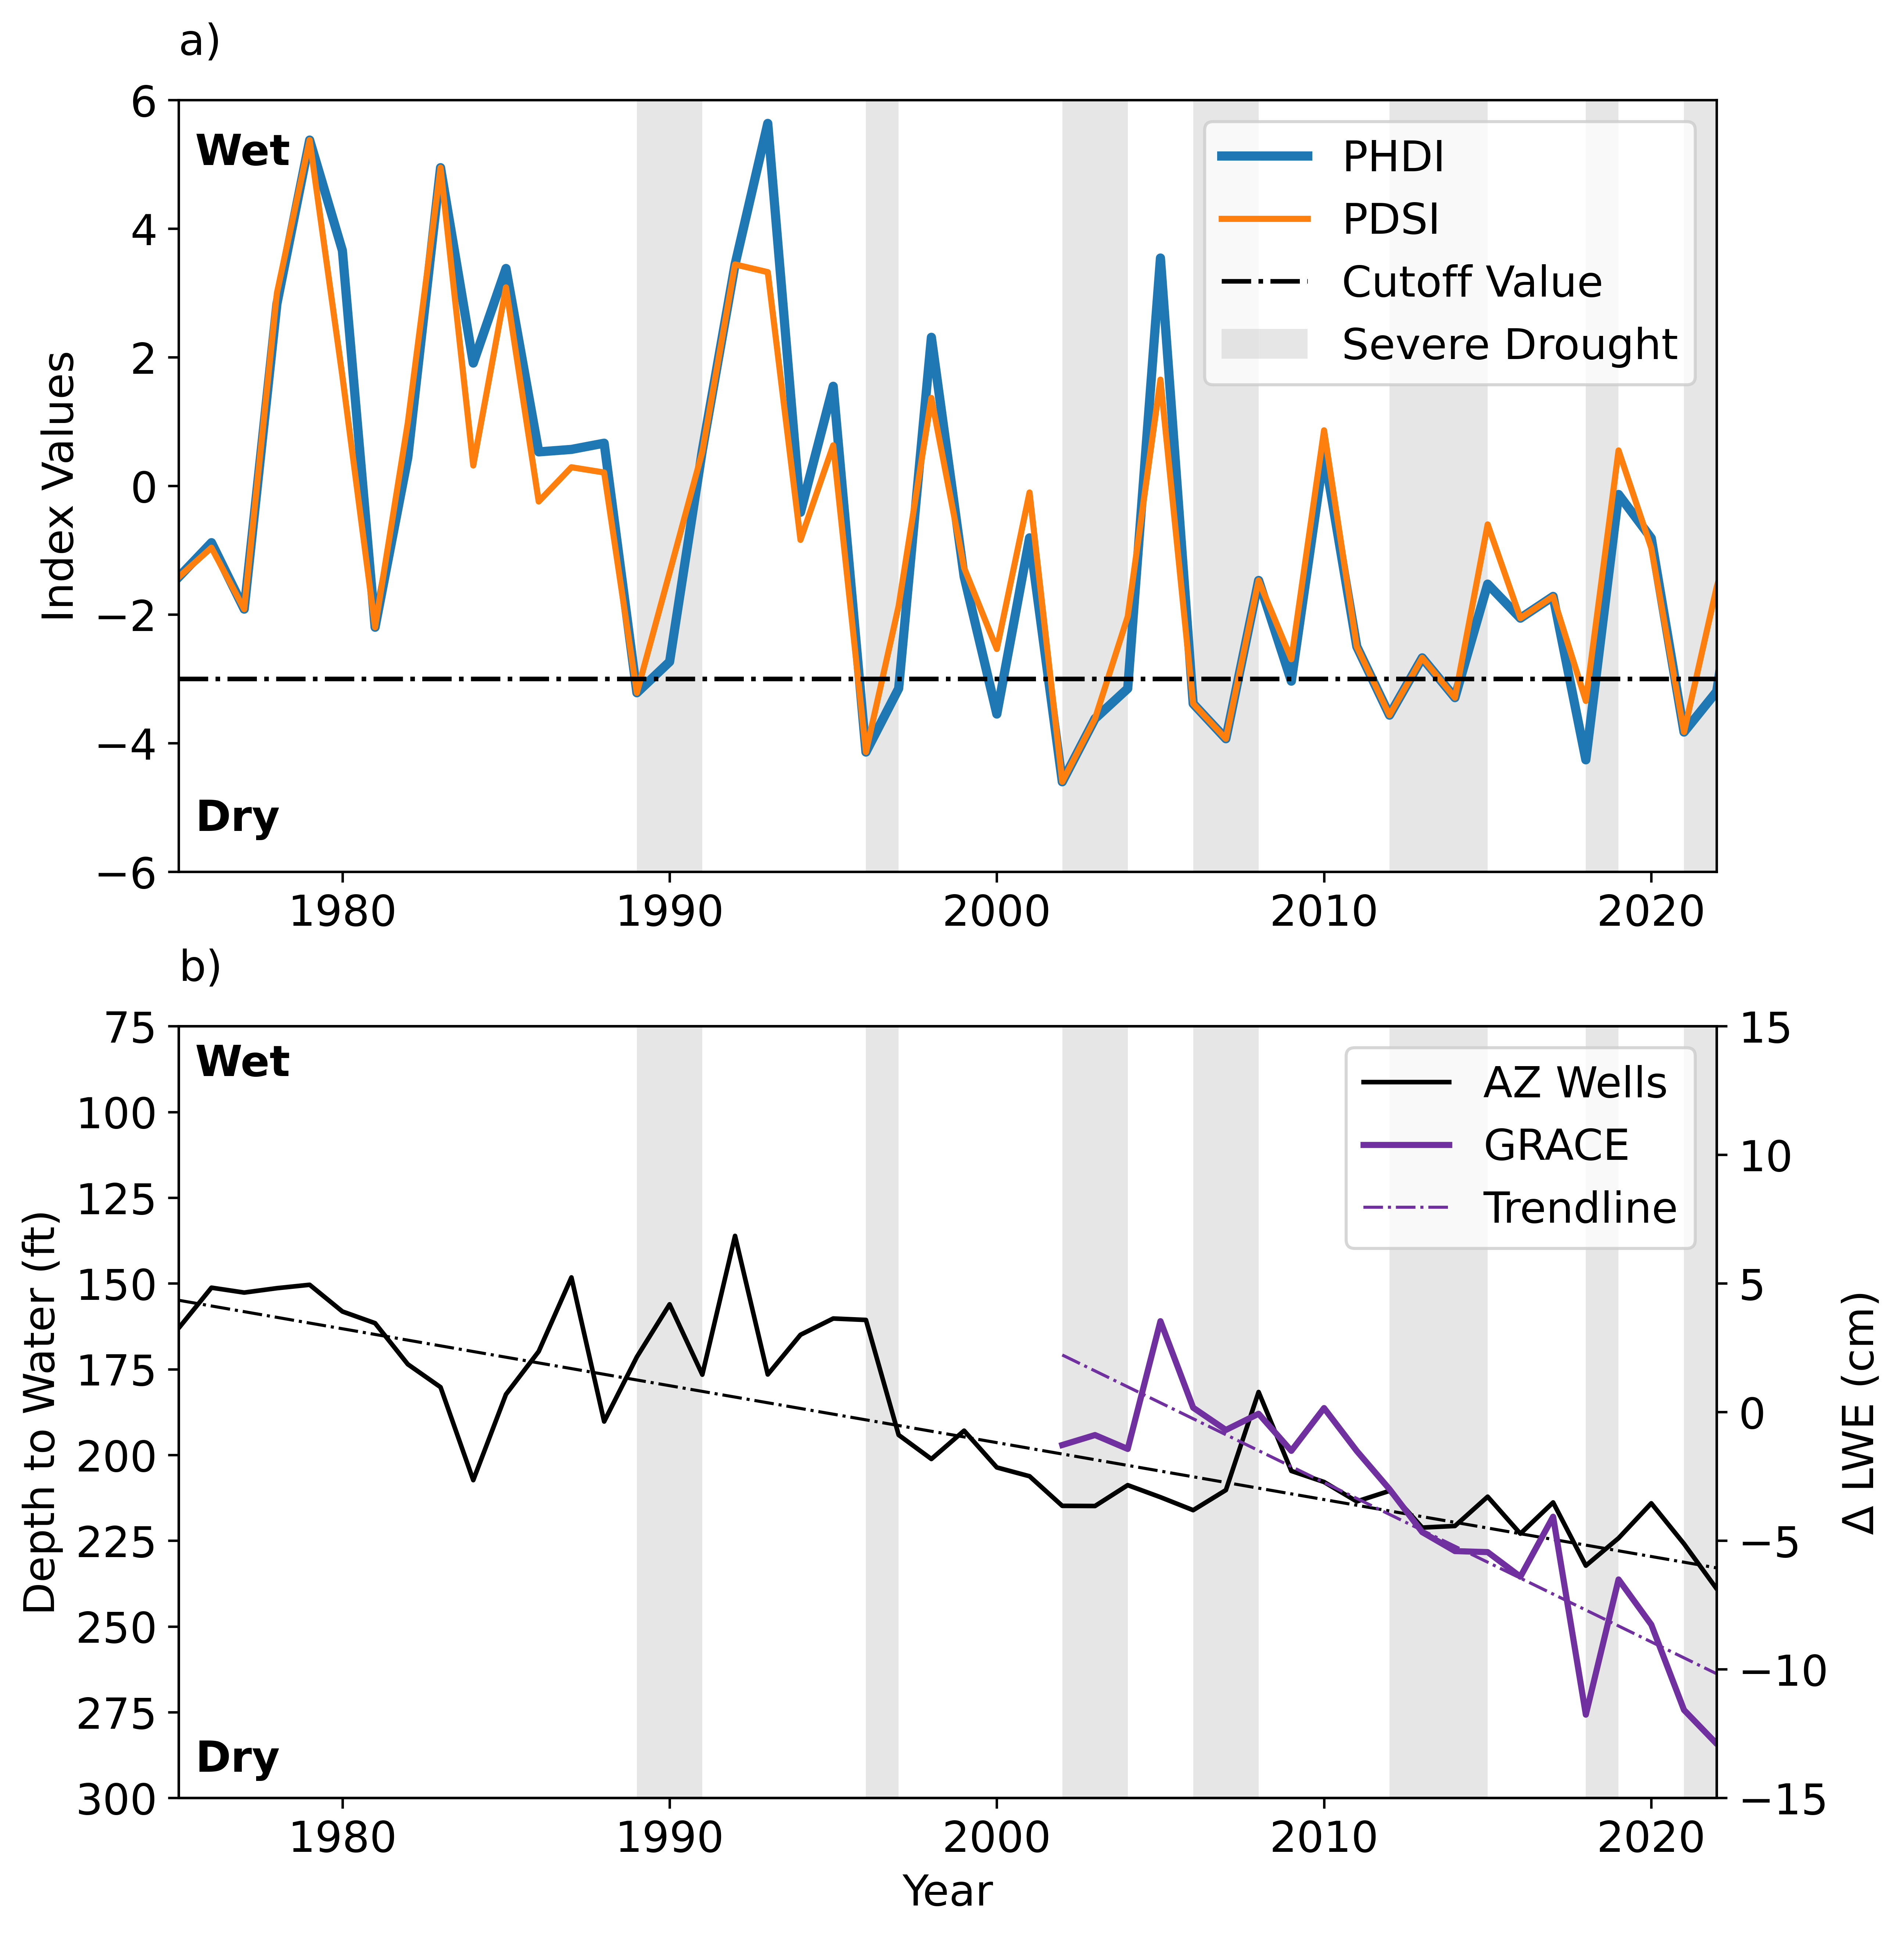

In [13]:
# %% Figure 3
minyear = 1975
maxyear = 2022
fsize = 14

fig, ax = plt.subplots(2, 1, figsize=(9, 10))

# Plot for the first graph
ax[0].plot(drought_indices['PHDI'], label='PHDI', lw=3)
ax[0].plot(drought_indices['PDSI'], label='PDSI', lw=2)
ax[0].plot(drought_indices['dry'], '-.', label='Cutoff Value', color='black', zorder=5)

# Drought Year Shading
drought_years = [(1989, 1991), (1996, 1997), (2021, 2022), (2002, 2004), (2006, 2008), (2012, 2015), (2018, 2019)]
for start, end in drought_years:
    ax[0].axvspan(start, end, color=drought_color, alpha=0.5, lw=0, label="Severe Drought" if start == 1989 else "")

ax[0].set_xlim(minyear, maxyear)
ax[0].set_ylim(-6, 6)
# ax[0].grid(visible=True, which='major')
ax[0].grid(which='minor', color='#EEEEEE', lw=0.8)
# ax[0].set_xlabel('Year', fontsize=fsize)
ax[0].set_ylabel('Index Values', fontsize=fsize)
ax[0].legend(loc='best', fontsize=fsize)
ax[0].set_title('a)', fontsize=fsize, loc='left', pad=15)
ax[0].tick_params(axis='y', labelsize=fsize)
ax[0].tick_params(axis='x', labelsize=fsize, rotation=0)

# Data preparation for the second graph
adb_statemean = annual_db2.mean()
adb_meandf = pd.DataFrame(adb_statemean)
# adb_meandf = adb_meandf.index.astype(int)
f = adb_meandf
f.reset_index(inplace=True)
f['index'] = pd.to_numeric(f['index'])
f['index'] = f['index'].astype(int)
f.set_index('index', inplace=True)

adb_meandf = f

ds = adb_meandf

betterlabels = ['State Average DTW'] 

f = ds[(ds.index >= minyear) & (ds.index <= maxyear)]
columns = ds.columns
column_list = ds.columns.tolist()

stats = pd.DataFrame()
for i in column_list:
        df = f[i]
        # df = f[i].pct_change()
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 'int':intercept, 
                              'rsq':r_value*r_value, 'p_val':p_value, 
                              'std_err':std_err, 'mean': np.mean(y),
                              'var': np.var(y),'sum': np.sum(y)},
                              ignore_index=True)

stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)
# # -- Data visualization --
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
m1 = round(stats1.loc['slope',betterlabels[0]], 2)
yint1 = round(stats1.loc['int',betterlabels[0]], 2)
rsq1 = round(stats1.loc['rsq', betterlabels[0]], 4)
pval1 = round(stats1.loc['p_val', betterlabels[0]], 4)
yf1 = (m1*xf)+yint1

ax[1].plot(xf1, yf1,"-.",color=az_wells_color, lw=1)
ax[1].plot(ds.index, ds, label='AZ Wells', color='black', zorder=2)

# Add drought shading
for start, end in drought_years:
    ax[1].axvspan(start, end, color=drought_color, alpha=0.5, lw=0)

ax[1].set_xlim([minyear, maxyear])
ax[1].set_ylim(300, 75)
ax[1].set_xlabel('Year', fontsize=fsize)
ax[1].set_ylabel('Depth to Water (ft)', fontsize=fsize)
ax[1].set_title('b)', fontsize=fsize, loc='left', pad=15)

# GRACE trendline
grace_df = grace_yearly[(grace_yearly.index >= 2002) & (grace_yearly.index <= maxyear)]
x_grace = np.array(grace_df.index.values, dtype=float)
y_grace = np.array(grace_df['0'].values, dtype=float)
slope_grace, intercept_grace, r_value_grace, p_value_grace, std_err_grace = sp.linregress(x_grace, y_grace)

xf_grace = np.linspace(min(x_grace), max(x_grace), 100)
yf_grace = (slope_grace * xf_grace) + intercept_grace

# Secondary axis for GRACE data
ax2 = ax[1].twinx()
ax2.plot(grace_yearly.index, grace_yearly['0'], label='GRACE', color=grace_color, zorder=1, lw=2)
ax2.plot(xf_grace, yf_grace, "-.", color=grace_color, lw=1,label='Trendline')  # Trendline for GRACE
ax2.set_ylim([-15, 15])
ax2.set_ylabel(u'Δ LWE (cm)', fontsize=14)

# Combine legends
lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax[1].legend(lines + lines2, labels + labels2, loc='upper right', fontsize=fsize)

ax[1].tick_params(axis='y', labelsize=fsize)
ax2.tick_params(axis='y', labelsize=fsize)
ax[1].tick_params(axis='x', labelsize=fsize, rotation=0)

# Adding text inside the plot
ax[0].text(minyear+0.5, 5.5, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax[0].text(minyear+0.5, -5.5, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')
ax[1].text(minyear+0.5, 80, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax[1].text(minyear+0.5, 295, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

fig.set_dpi(600.0)
plt.savefig(figurepath + '/Figure3', bbox_inches='tight')
plt.show()

Setting up the analysis period

In [14]:
minyear_grace = 2002 # Year GRACE was launched
maxyear = 2022

# %% Figure out which water level database you want
cat_wl2 = grace_yearly.copy() 

# Water Analysis period
wlanalysis_period_grace = cat_wl2[(cat_wl2.index>=minyear_grace)&(cat_wl2.index<=maxyear)]

In [15]:
# Enter min year and max year of timeframe
# minyear = 2000 # When Lakemead started to go into drought
minyear_wells = 2002

# %% Figure out which water level database you want
cat_wl2 = annual_db2.copy()
cat_wl2 = cat_wl2.transpose()
cat_wl2 = cat_wl2.reset_index()
cat_wl2['index'] = pd.to_numeric(cat_wl2['index'], errors='coerce')
cat_wl2.index = cat_wl2.index.astype('int64')
cat_wl2 = cat_wl2.set_index('index')

# Water Analysis period for wells
wlanalysis_period_AZwells = cat_wl2[(cat_wl2.index>=minyear_wells)&(cat_wl2.index<=maxyear)]
wlanalysis_period_AZwells.head()

Combo_ID  83578            84067            84442            84455            \
index                                                                          
2002.0                NaN              NaN              NaN              NaN   
2003.0                NaN              NaN              NaN              NaN   
2004.0                NaN              NaN              NaN              NaN   
2005.0                NaN              NaN              NaN              NaN   
2006.0                NaN              NaN              NaN              NaN   

Combo_ID  84460            84598            84614            84626            \
index                                                                          
2002.0                NaN              NaN              NaN              NaN   
2003.0                NaN              NaN              NaN              NaN   
2004.0                NaN              NaN              NaN              NaN   
2005.0                NaN              NaN              NaN              NaN   
2006.0                NaN              NaN              NaN              NaN   

Combo_ID  84630            84633            ...  364515111034001  \
index                                       ...                    
2002.0                NaN              NaN  ...              NaN   
2003.0                NaN              NaN  ...              NaN   
2004.0                NaN              NaN  ...              NaN   
2005.0                NaN              NaN  ...              NaN   
2006.0                NaN              NaN  ...              NaN   

Combo_ID  364528113101401  364529109292701  364537109390801  364550112401201  \
index                                                                          
2002.0                NaN              NaN              NaN              NaN   
2003.0                NaN              NaN              NaN              NaN   
2004.0                NaN              NaN            -36.8              NaN   
2005.0                NaN              NaN              NaN              NaN   
2006.0                NaN              NaN              NaN              NaN   

Combo_ID  364552109315901  364613109510801  364614114054601  364619114054801  \
index                                                                          
2002.0                NaN              NaN              NaN              NaN   
2003.0                NaN              NaN              NaN              NaN   
2004.0                NaN              NaN              NaN              NaN   
2005.0                NaN              NaN              NaN              NaN   
2006.0                NaN              NaN              NaN              NaN   

Combo_ID  364625113595501  
index                      
2002.0                NaN  
2003.0                NaN  
2004.0                NaN  
2005.0                NaN  
2006.0                NaN  

[5 rows x 168101 columns]

In [16]:
# Calculate the mean across columns for each row
average_per_year = wlanalysis_period_AZwells.mean(axis=1)

# Create a new DataFrame with years as rows and an 'Average' column
average_df_AZ = pd.DataFrame(average_per_year)

# Display the resulting DataFrame
average_df_AZ.head()

0
index             
2002.0  214.843555
2003.0  214.888602
2004.0  208.806658
2005.0  212.319045
2006.0  216.104375

In [17]:
# Narrowing the drought indices to be during our study period
drought_indices_wells = drought_indices[(drought_indices.index>=minyear_wells)&(drought_indices.index<=maxyear)]
drought_indices_grace = drought_indices[(drought_indices.index>=2002)&(drought_indices.index<=maxyear)]

For comparing to drought indices

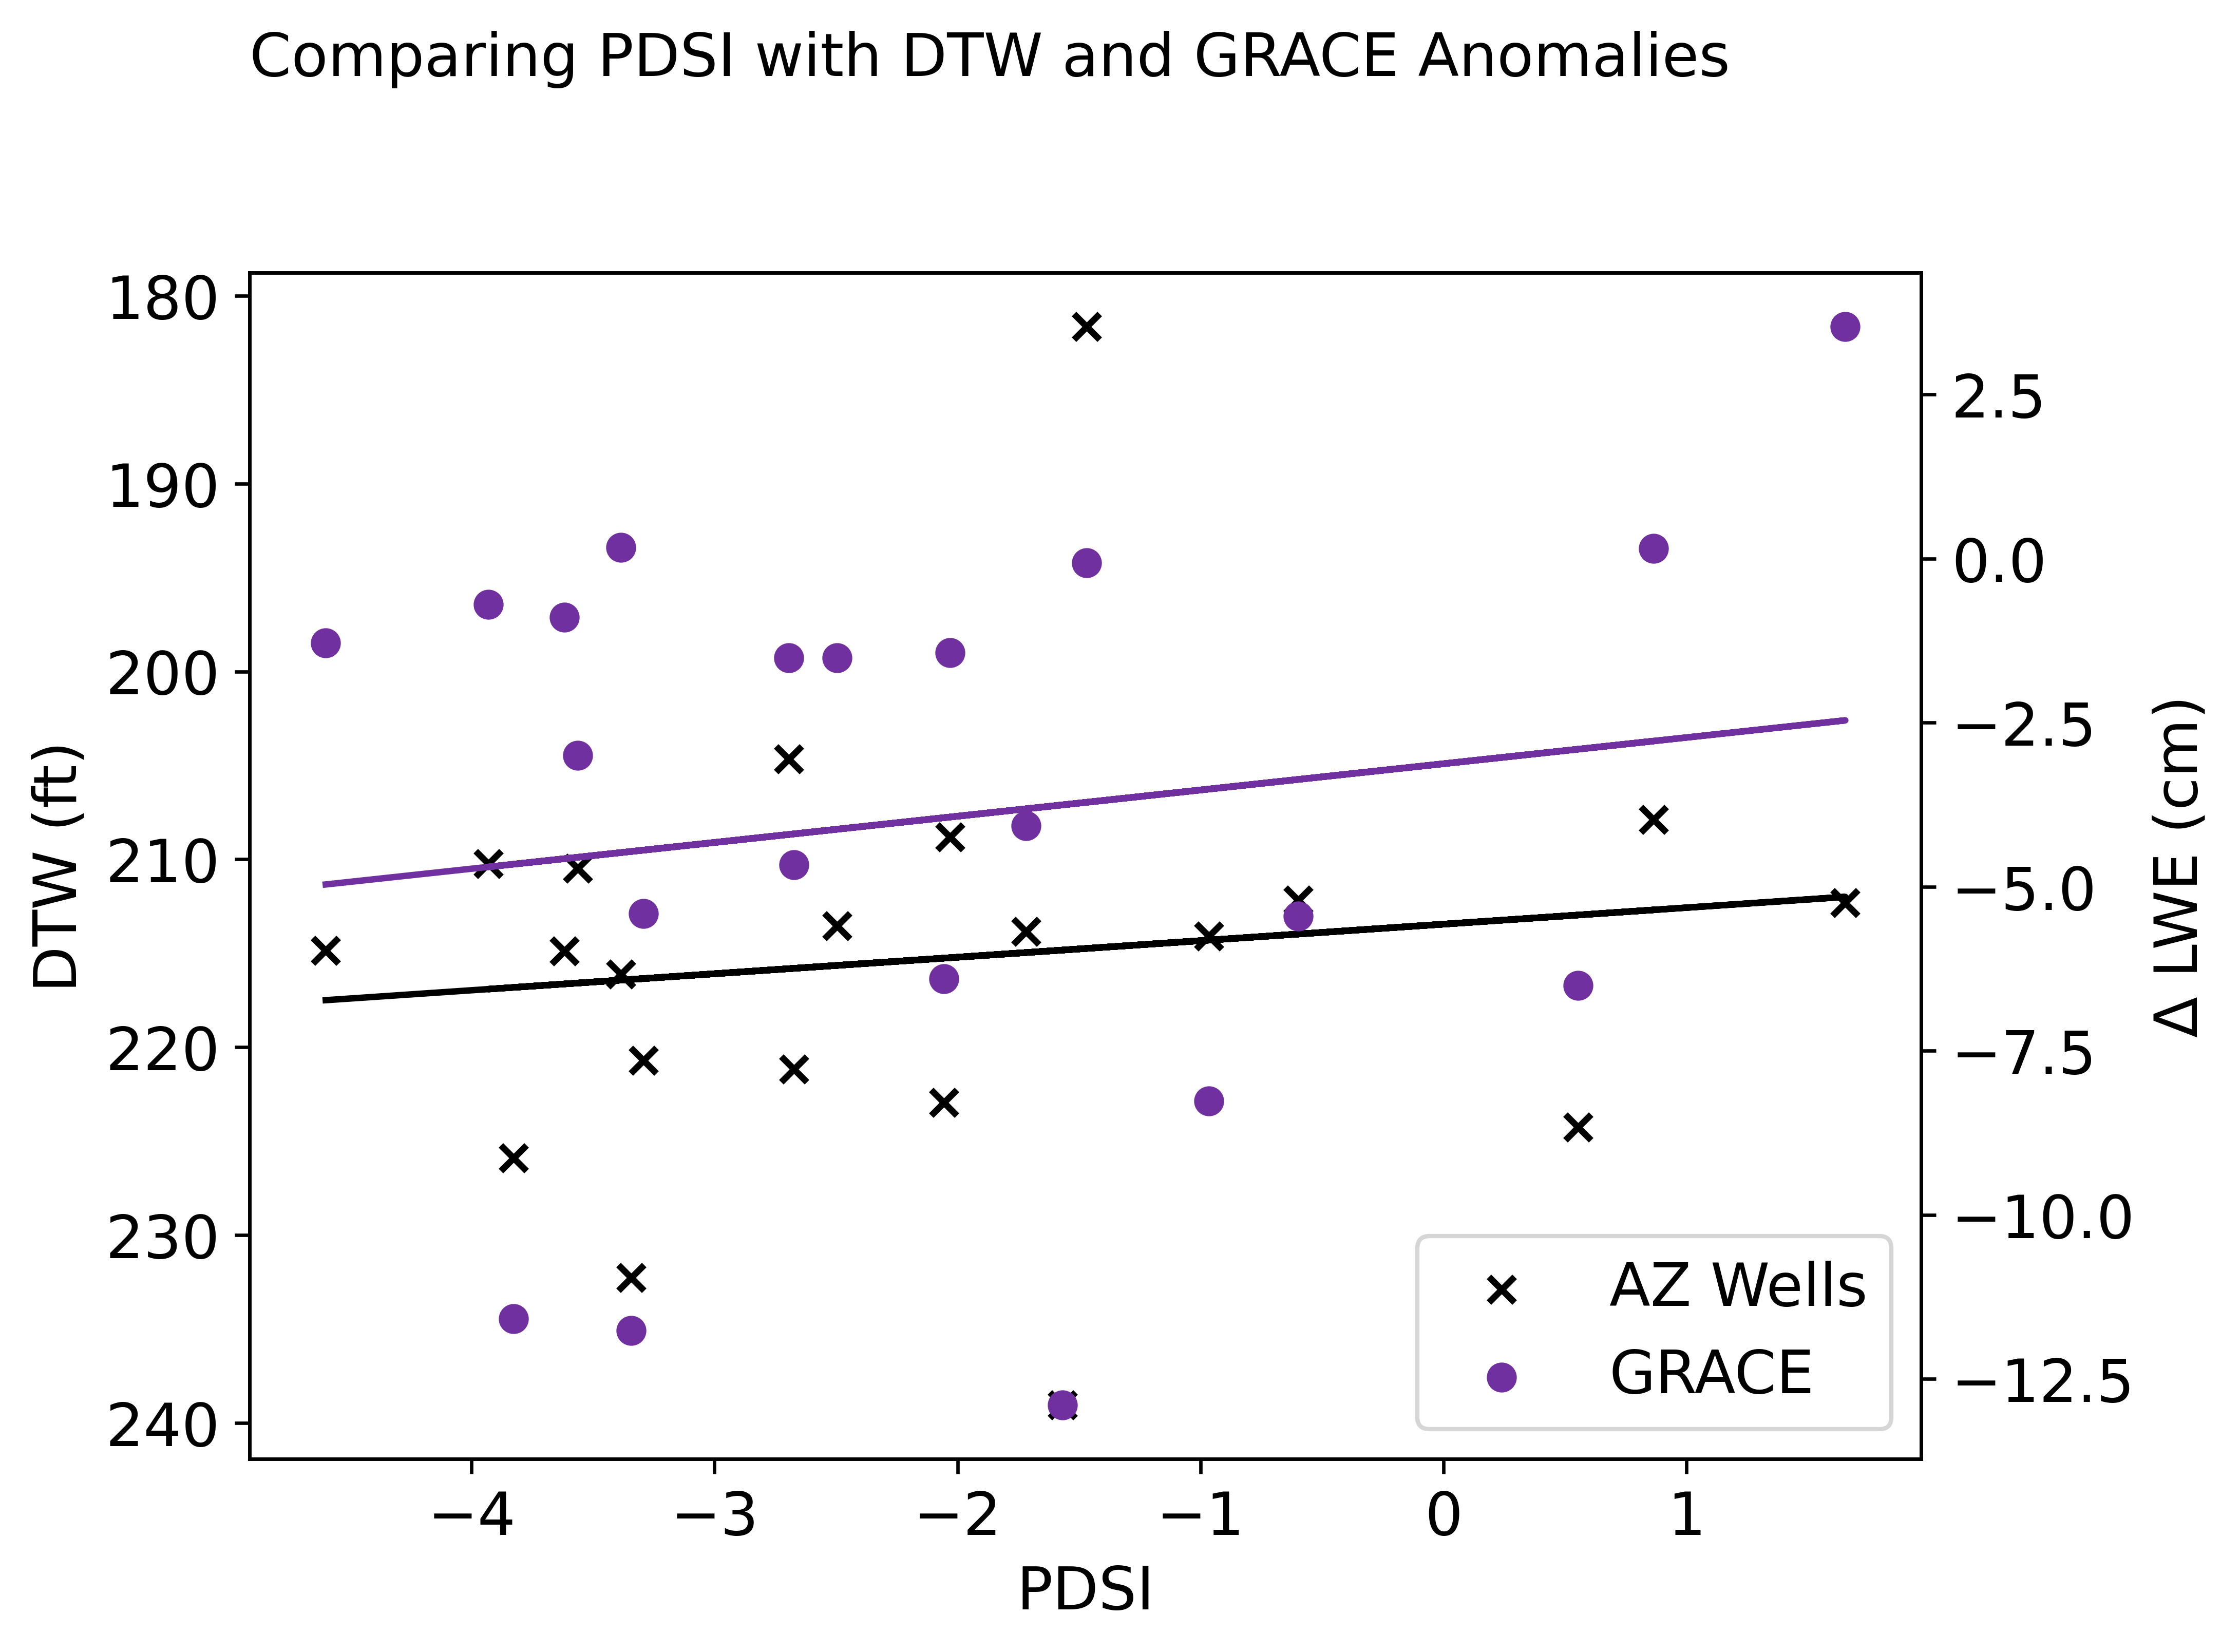

Results for GRACE Correlation (2002-2022):
Kendall Correlation coefficient
 0:
  tau = -0.029
  pval = 0.8815
Spearman Correlation coefficient
 0:
  rho = -0.026
  pval = 0.911
Pearson Correlation coefficient
 0:
  rsq = 0.023
  pval = 0.5072

Results for ADWR Well (2002-2022):
Kendall Correlation coefficient
 0:
  tau = -0.095
  pval = 0.5706
Spearman Correlation coefficient
 0:
  rho = -0.194
  pval = 0.4007
Pearson Correlation coefficient
 0:
  rsq = 0.017
  pval = 0.5734



In [18]:
ds = wlanalysis_period_grace
ds2 = average_df_AZ
drought = drought_indices_wells

indice = 'PDSI'
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0

betterlabels = 'GRACE' 
betterlabels2 = 'AZ Wells' 

test_name = "GRACE Correlation ("+str(minyear_grace)+"-"+str(maxyear)+")"
test_name2 = "ADWR Well ("+str(minyear_wells)+"-"+str(maxyear)+")"

vertlabel1 = u'Δ LWE (cm)'
vertlabel2 = 'DTW (ft)'

subplot = ''

result = cf.correlation_test_2y(ds,ds2,drought,indice,lag
                                ,test_name,test_name2
                                ,betterlabels,betterlabels2
                                ,grace_color,az_wells_color
                                ,vertlabel1,vertlabel2, subplot)
print(result)

For Calculating Anomlies

In [19]:
# Anomaly's
ds = wlanalysis_period_grace.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = wlanalysis_period_grace.copy()
lwe_anomalys_grace = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        trend_df[i] = (ds.index*slope) + intercept
        lwe_anomalys_grace[i] = ds[i] - trend_df[i]
        

lwe_anomalys_grace.head()

0
year          
2002 -3.500186
2003 -2.492875
2004 -2.413919
2005  3.172629
2006  0.429620

In [20]:
# Anomaly's
ds = average_df_AZ.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = average_df_AZ.copy()
dtw_anomalys_AZwells = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)

        # Correcting the index to be integers
        trend_df.index = trend_df.index.astype(int)
        ds.index = ds.index.astype(int)

        trend_df[i] = (ds.index*slope) + intercept
        dtw_anomalys_AZwells[i] = ds[i] - trend_df[i]
        
dtw_anomalys_AZwells.index = dtw_anomalys_AZwells.index.astype('int64')
dtw_anomalys_AZwells.head()

0
index          
2002   9.946906
2003   8.948762
2004   1.823628
2005   4.292824
2006   7.034963

Creating a timeseries plot of anomalies

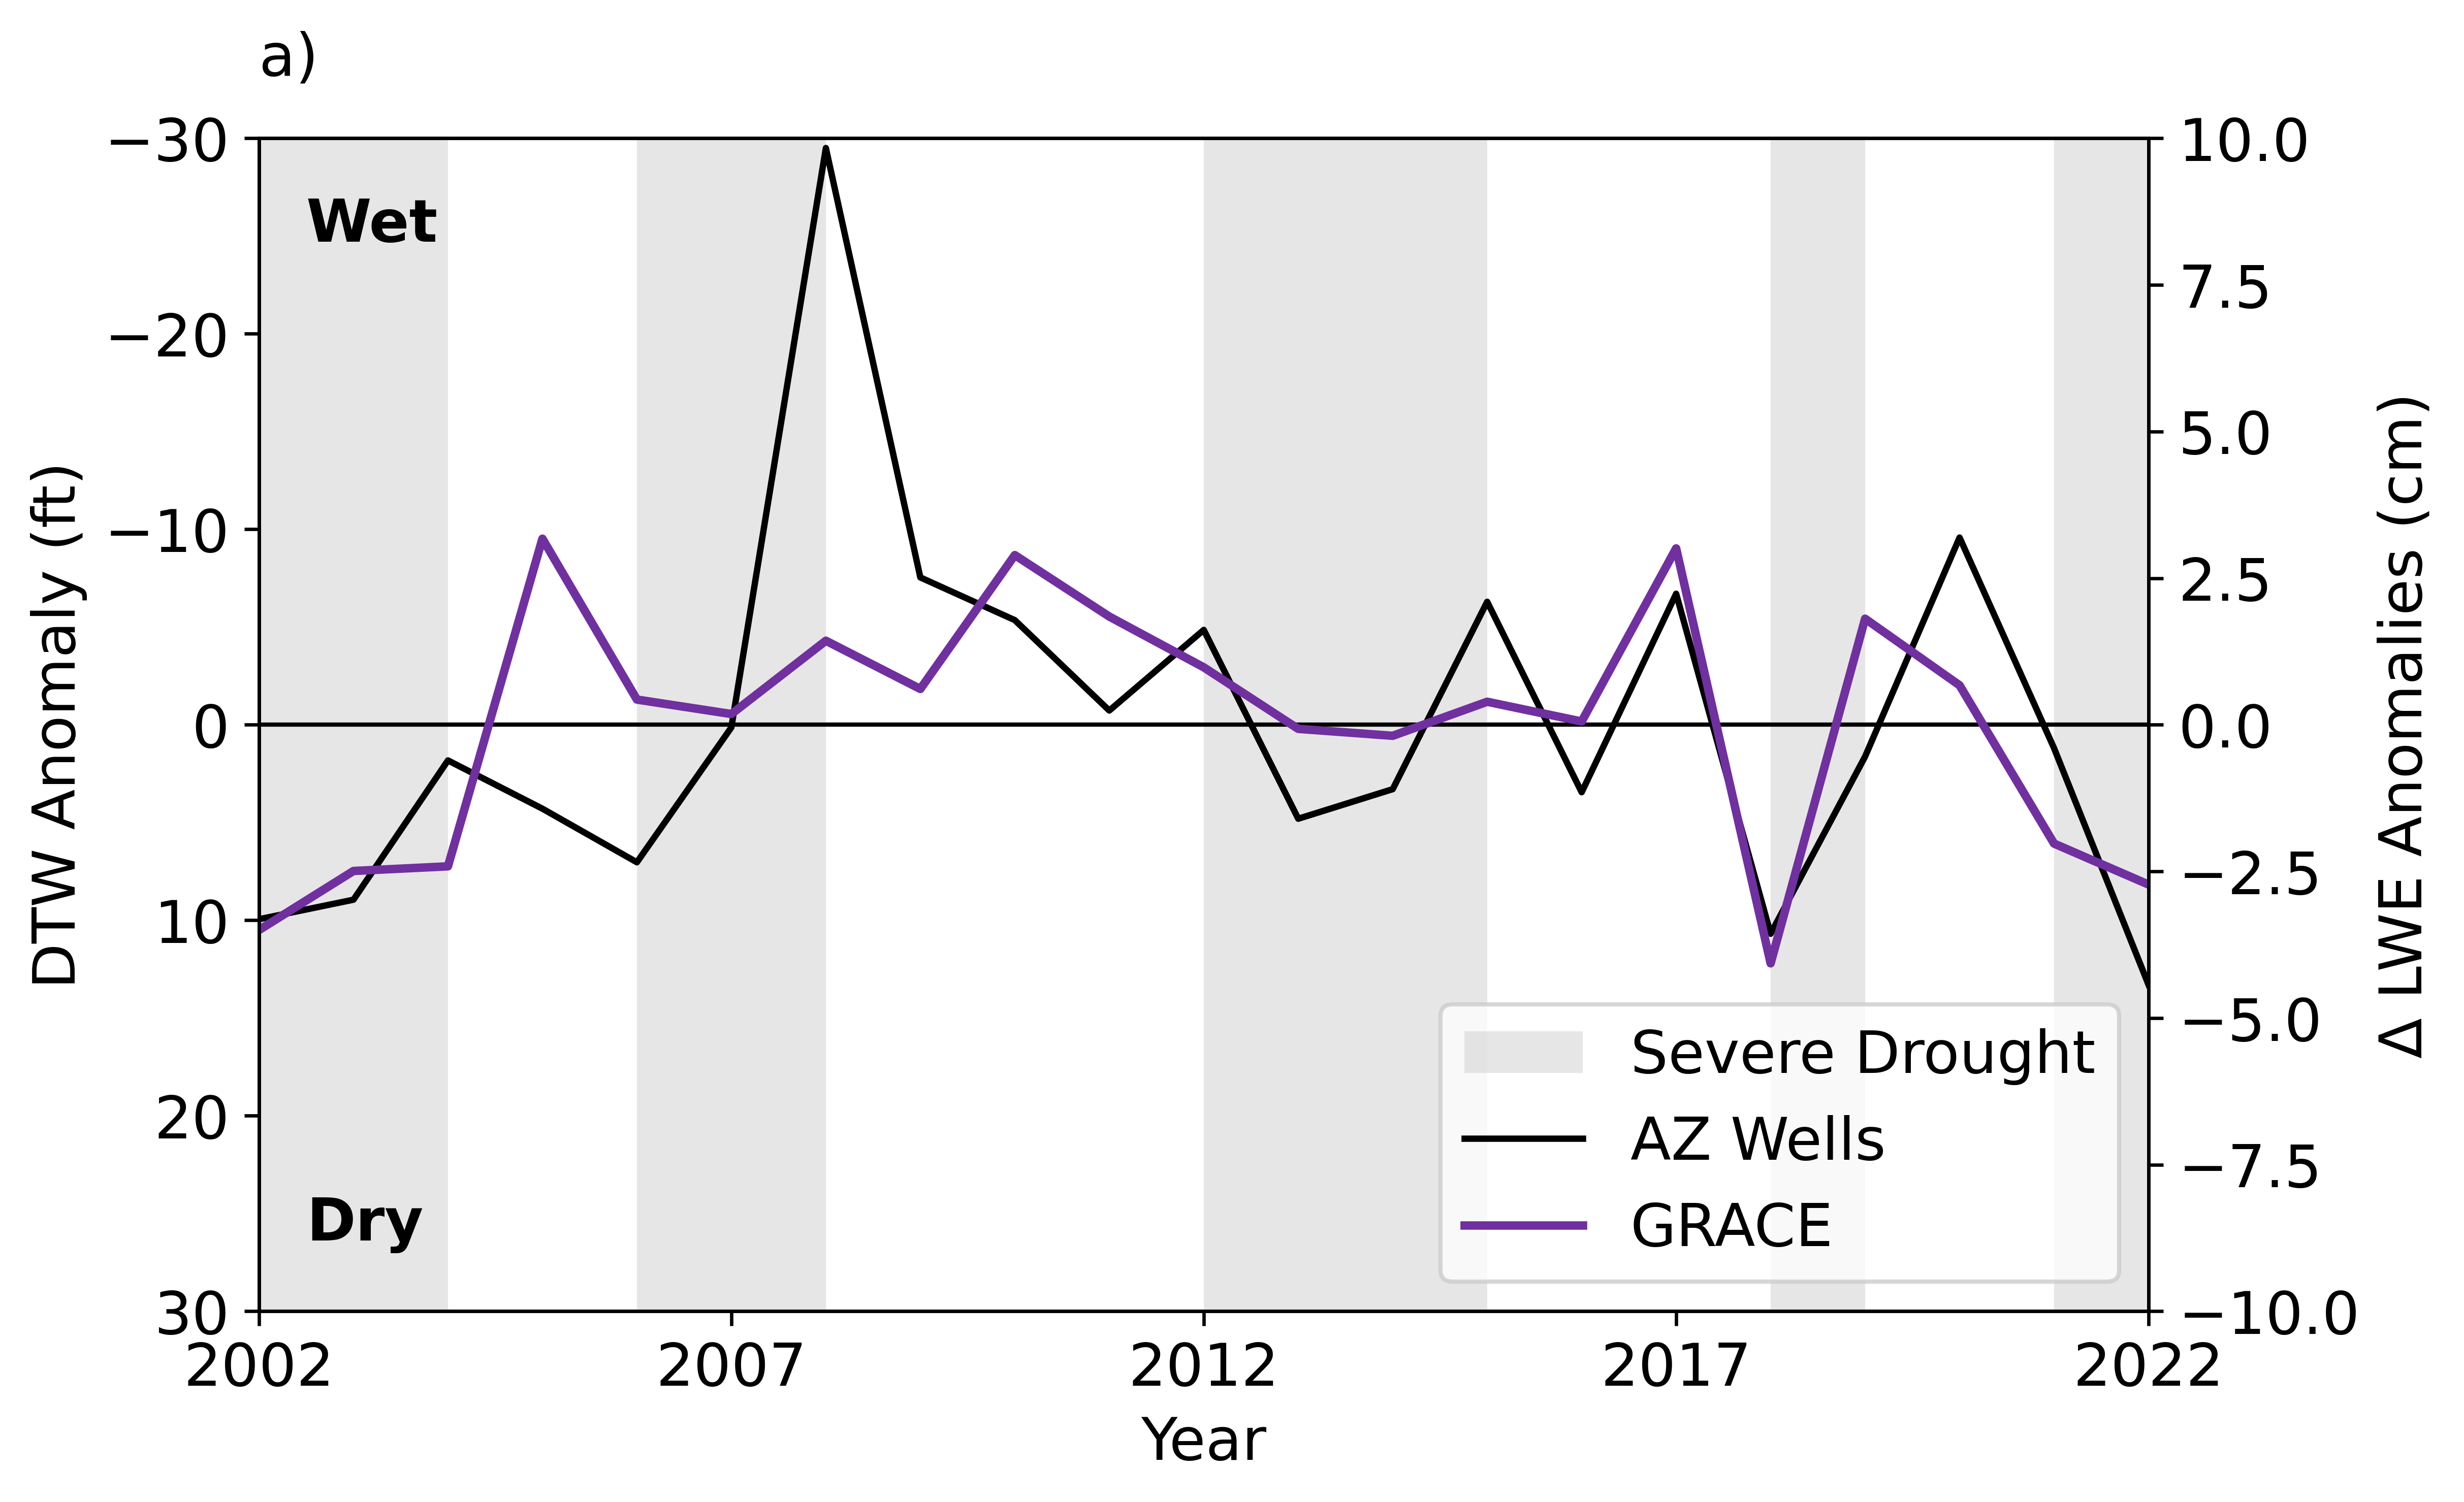

In [23]:
# For both GRACE and AZ Wells
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells

min_yr = 2002
mx_yr = 2022

fig, ax = plt.subplots(1, 1, figsize = (8,5))

fsize = 14
well_ylimit = 30 #ft
grace_ylimit = 10 #cm

# Severe Drought Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought")
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

plt.axhspan(0,0,color='black',lw=1)

# ax.legend(loc='upper right')

# Plotting AZ on a secondary axis
ax.plot(ds2[0], 
         label='AZ Wells', 
         color='black',zorder=1)
ax.set_ylim([well_ylimit, -well_ylimit])

# Plotting GRACE
ax2 = ax.twinx()
ax2.plot(ds['0'], 
        label='GRACE', 
        color=grace_color,
        lw=2) 
ax2.set_ylim(-grace_ylimit,grace_ylimit)

# Adjust the x-axis and other labels
ax.set_xlim(min_yr,mx_yr)
ax.set_xlabel('Year', fontsize=fsize)
ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)
ax2.set_ylabel(u'Δ LWE Anomalies (cm)',fontsize=fsize)
ax2.tick_params(axis='y', labelsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)

# ax2.set_ylim(ax2.get_ylim()[::-1])

# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax2.legend(loc='lower right')
ax.set_title('a)',loc='left',pad=15,fontsize = fsize)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right', fontsize=fsize)

# Adding text inside the plot
ax.text(min_yr+0.5, 3-well_ylimit, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, well_ylimit-3, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

plt.savefig(figurepath+'/Figure4a', bbox_inches = 'tight')

Running correlation tests and plotting a scatterplot

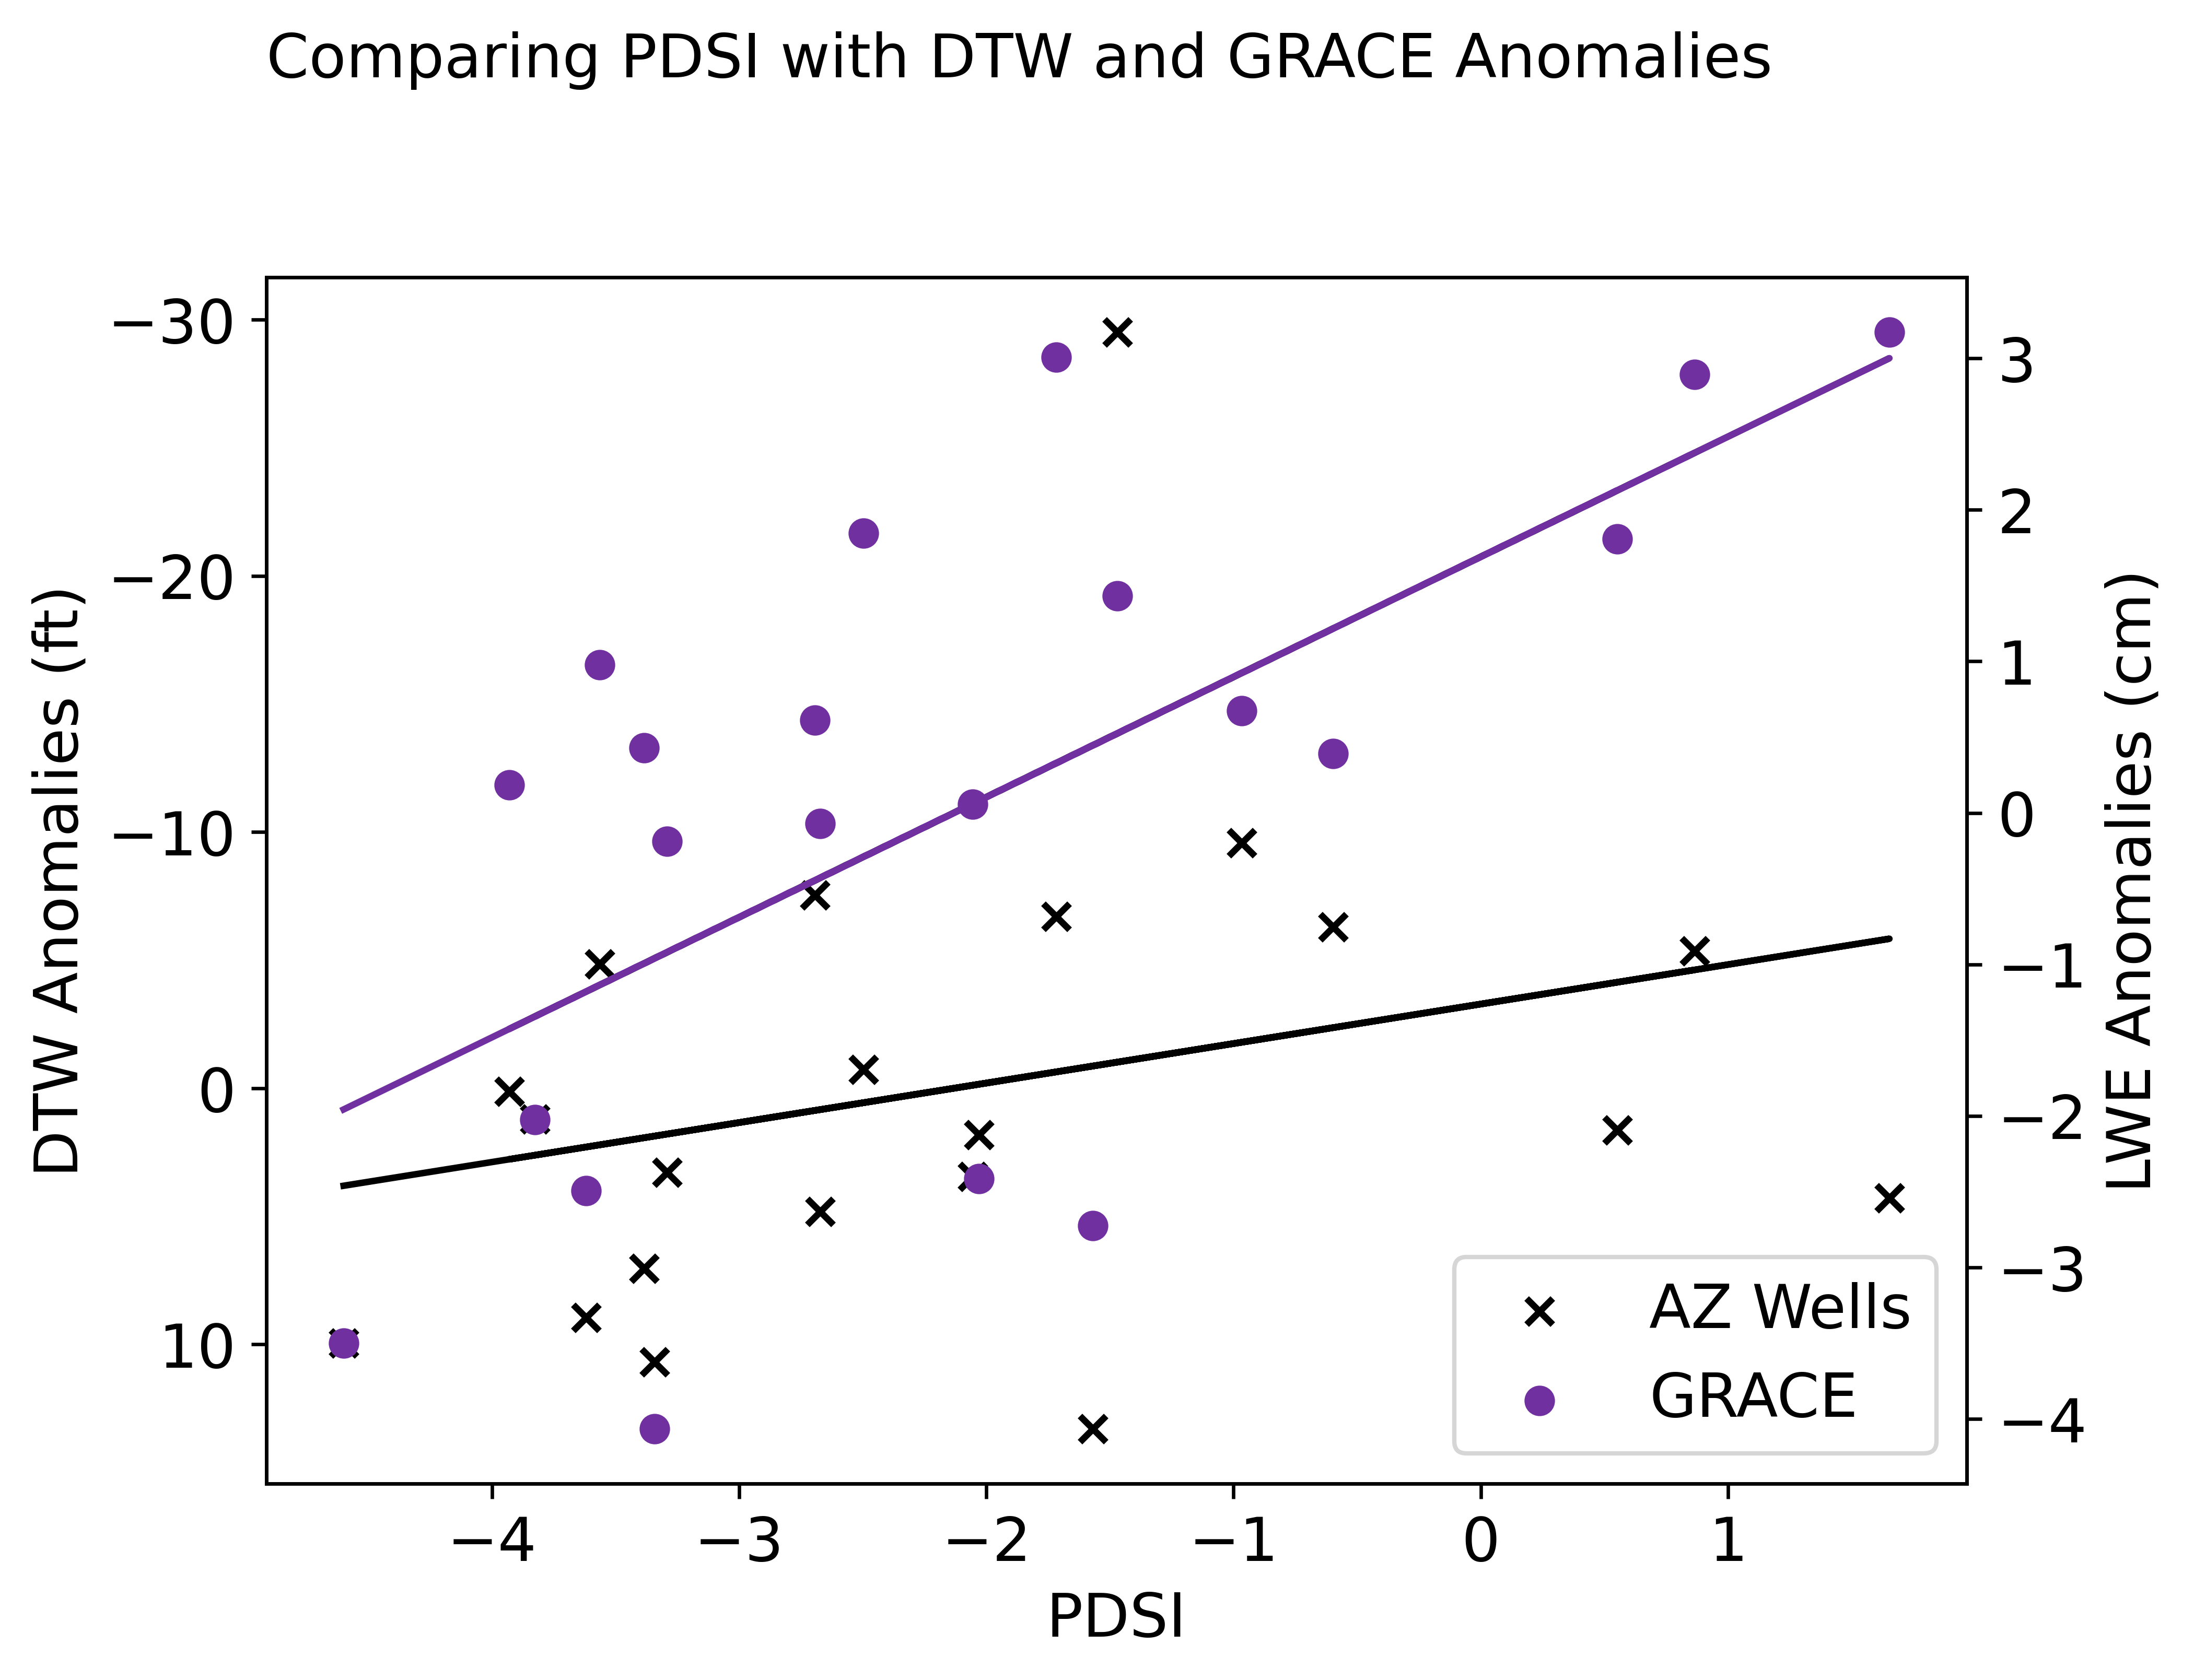

Results for GRACE Anomaly Correlation (2002-2022):
Kendall Correlation coefficient
 0:
  tau = 0.429
  pval = 0.0061
Spearman Correlation coefficient
 0:
  rho = 0.59
  pval = 0.0049
Pearson Correlation coefficient
 0:
  rsq = 0.393
  pval = 0.0023

Results for ADWR Well Anomalies (2002-2022):
Kendall Correlation coefficient
 0:
  tau = -0.229
  pval = 0.1576
Spearman Correlation coefficient
 0:
  rho = -0.347
  pval = 0.1236
Pearson Correlation coefficient
 0:
  rsq = 0.077
  pval = 0.2227



In [24]:
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells
drought = drought_indices_wells

indice = 'PDSI'
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0

betterlabels = 'GRACE' 
betterlabels2 = 'AZ Wells' 

test_name = "GRACE Anomaly Correlation ("+str(minyear_grace)+"-"+str(maxyear)+")"
test_name2 = "ADWR Well Anomalies ("+str(minyear_wells)+"-"+str(maxyear)+")"

vertlabel1 = 'LWE Anomalies (cm)'
vertlabel2 = 'DTW Anomalies (ft)'

subplot = ''

result = cf.correlation_test_2y(ds,ds2,drought,indice,lag
                                ,test_name,test_name2
                                ,betterlabels,betterlabels2
                                ,grace_color,az_wells_color
                                ,vertlabel1,vertlabel2,subplot
                                )

print(result)

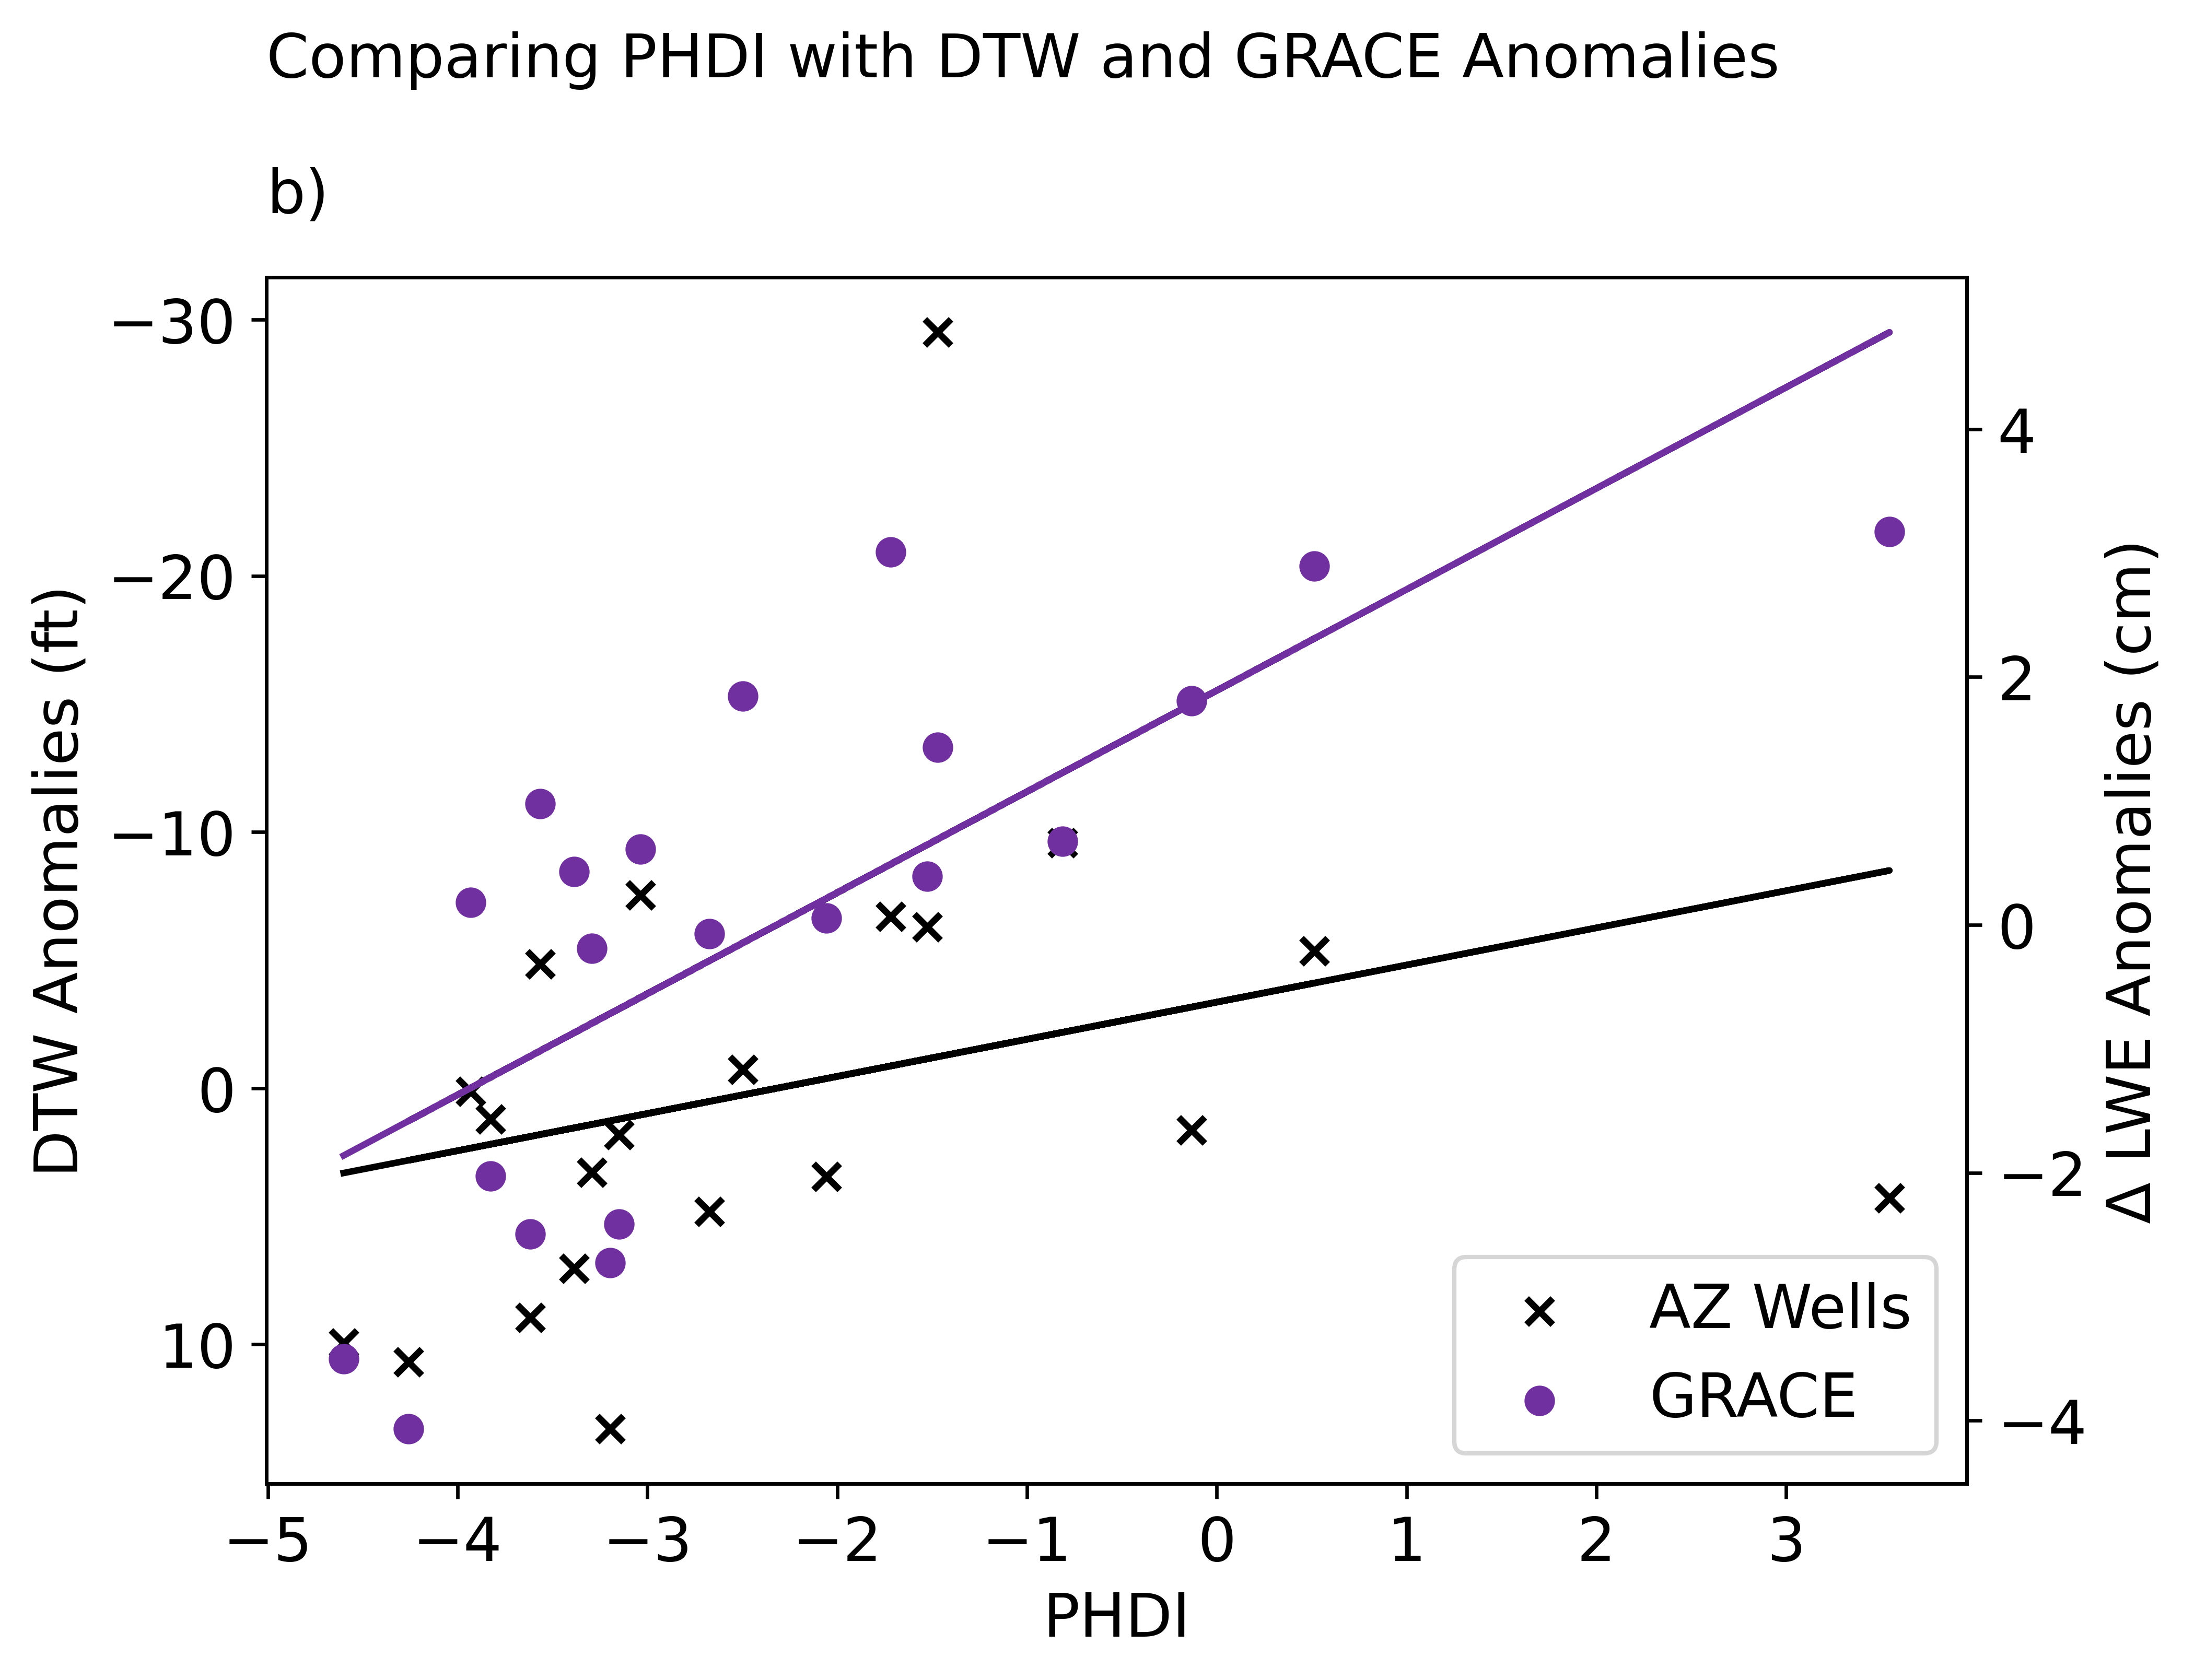

Results for GRACE Anomaly Correlation (2002-2022):
Kendall Correlation coefficient
 0:
  tau = 0.59
  pval = 0.0001
Spearman Correlation coefficient
 0:
  rho = 0.762
  pval = 0.0001
Pearson Correlation coefficient
 0:
  rsq = 0.531
  pval = 0.0002

Results for ADWR Well Anomalies (2002-2022):
Kendall Correlation coefficient
 0:
  tau = -0.352
  pval = 0.0262
Spearman Correlation coefficient
 0:
  rho = -0.505
  pval = 0.0195
Pearson Correlation coefficient
 0:
  rsq = 0.087
  pval = 0.1937



In [25]:
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells
drought = drought_indices_wells

indice = 'PHDI'
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0

betterlabels = 'GRACE' 
betterlabels2 = 'AZ Wells' 

test_name = "GRACE Anomaly Correlation ("+str(minyear_grace)+"-"+str(maxyear)+")"
test_name2 = "ADWR Well Anomalies ("+str(minyear_wells)+"-"+str(maxyear)+")"

vertlabel1 = u'Δ LWE Anomalies (cm)'
vertlabel2 = 'DTW Anomalies (ft)'

FigureNumber = '4'
subplot = 'b)'

result = cf.correlation_test_2y_savefig(ds,ds2,drought,indice,lag
                                ,test_name,test_name2
                                ,betterlabels,betterlabels2
                                ,grace_color,az_wells_color
                                ,vertlabel1,vertlabel2,FigureNumber,subplot
                                )

print(result)

This block is if you want to use a colorbar to code your data by year

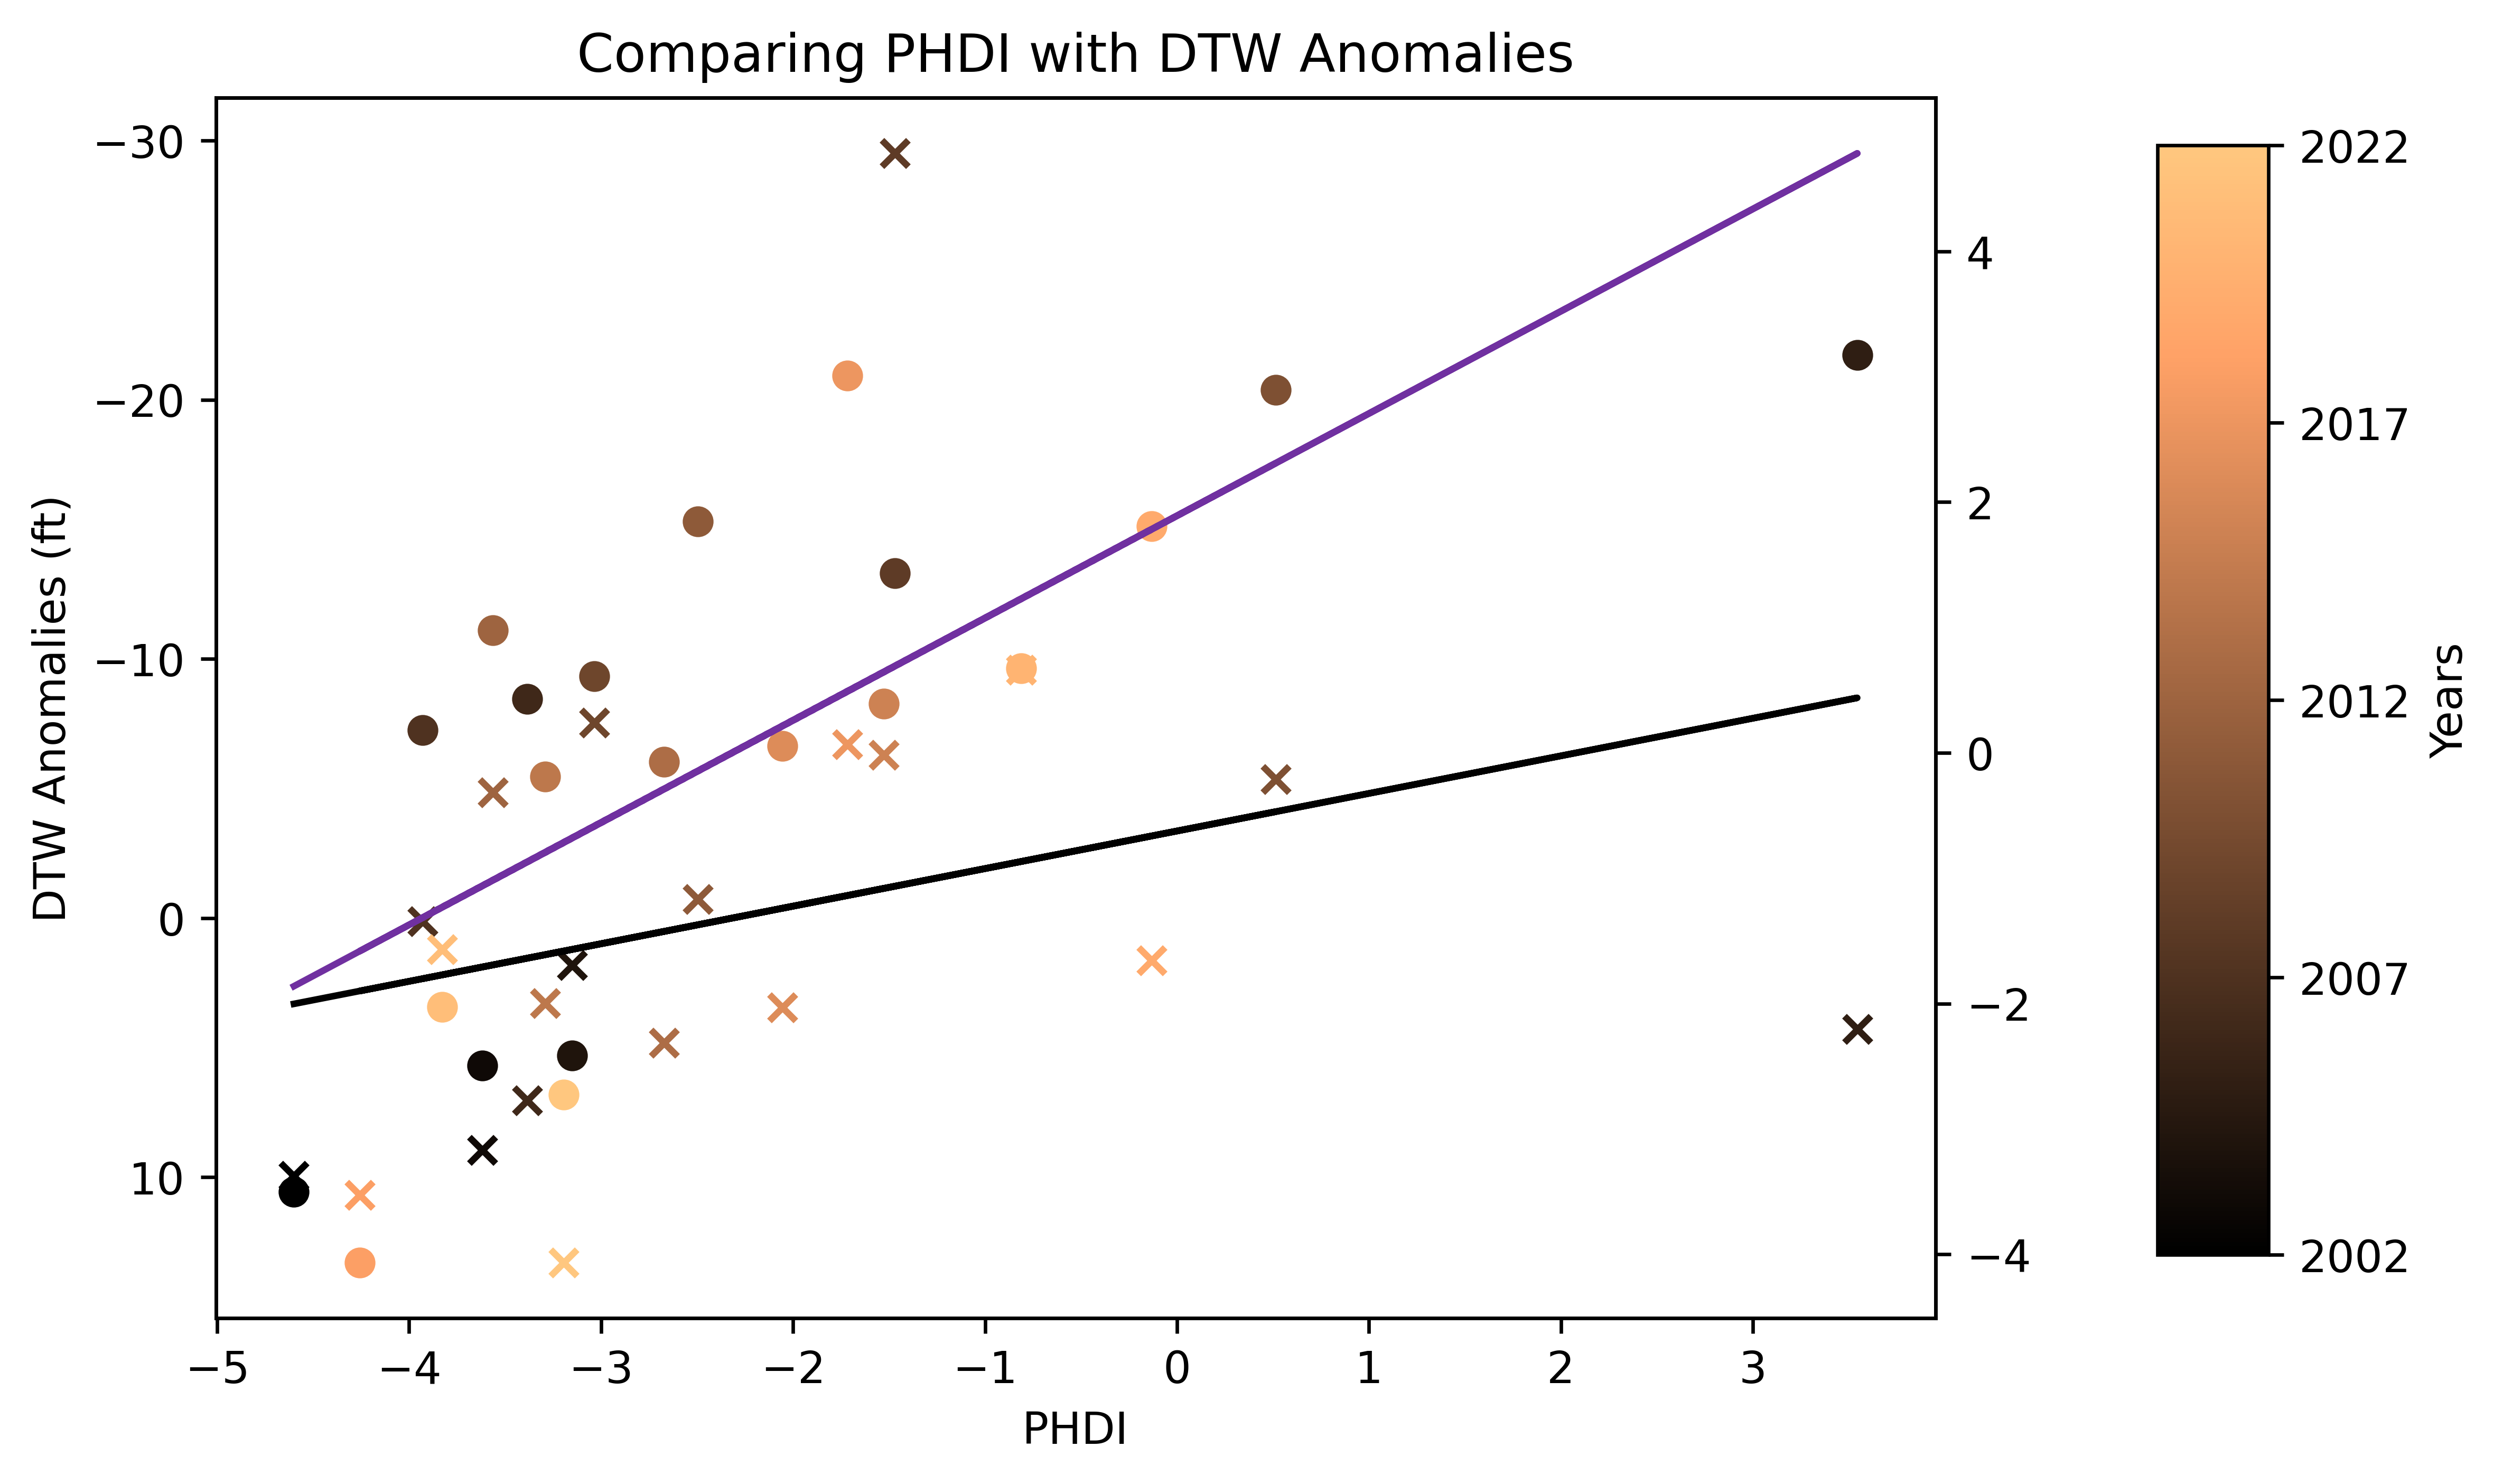

In [26]:
indice = 'PHDI'
# Scatterplot of correlation values
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells
ds2.columns = ds.columns

# # Define a threshold for extreme values
threshold = -20  # Example threshold value, adjust as needed

# # Replace extreme values with NaN
# ds2 = ds2.applymap(lambda x: np.nan if x < threshold else x)

# Ensure index names are consistent
ds.index.name = 'years'
ds2.index.name = 'years'
ds.index = ds.index.astype(int)
ds2.index = ds2.index.astype(int)

# Generate a color map based on the years
years = ds.index.union(ds2.index)
norm = mcolors.Normalize(vmin=years.min(), vmax=years.max())
colors = cm.copper(np.linspace(0, 1, len(years)))
color_map = {year: color for year, color in zip(years, colors)}

name = 'Comparing ' + indice + ' with DTW Anomalies'
columns = ds.columns
column_list = ds.columns.tolist()
columns2 = ds2.columns
column_list2 = ds2.columns.tolist()
betterlabels = ['GRACE']
betterlabels2 = ['AZ Wells']

fig, ax = plt.subplots(figsize=(7, 5))

x = drought_indices_grace[indice]
x2 = drought_indices_wells[indice]

# AZ Wells
for i, j in zip(column_list2, betterlabels2):
    y2 = ds2[i]
    for year in ds2.index:
        ax.scatter(x2.loc[year], y2.loc[year], label=f"{j} {year}", color=color_map[year], marker='x'
                   ,alpha=1
                   )
    valid_mask = ~y2.isna()
    valid_x2 = x2[valid_mask]
    valid_y2 = y2[valid_mask]

    if len(valid_x2) > 0 and len(valid_y2) > 0:  # Ensure there are enough points to fit
        z = np.polyfit(valid_x2, valid_y2, 1)
        p = np.poly1d(z)
        plt.plot(valid_x2, p(valid_x2), '-', color='black', alpha=1)  # Changed to black for clarity

# Create a secondary y-axis
ax2 = ax.twinx()

# GRACE
for i, j in zip(column_list, betterlabels):
    y = ds[i]
    for year in ds.index:
        ax2.scatter(x.loc[year], y.loc[year], label=f"{j} {year}", color=color_map[year])
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), '-', color=grace_color)  # Changed to black for clarity

# Reverse the order of the secondary y-axis
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xlabel(indice)
ax.set_ylabel('DTW Anomalies (ft)')
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Adding a color bar to represent the years, positioned manually
sm = plt.cm.ScalarMappable(cmap=cm.copper, norm=norm)
sm.set_array([])  # Only needed for older versions of matplotlib

# Specify the position of the color bar using a rectangle (x, y, width, height)
cbar_position = [1.0, 0.15, 0.05, 0.7]  # Adjust these values as needed
cbar_ax = fig.add_axes(cbar_position)
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Years')

# Set color bar ticks to show every 5 years
tick_locations = np.arange(years.min(), years.max() + 1, 5)
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_locations)

plt.show()

# plt.savefig(outputpath+name, bbox_inches='tight')


Max/Min the Anomalies by Drought Period

In [27]:
# %% Average Anomaly for drought periods
ds = lwe_anomalys_grace.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)

lwe_drawdown_grace = ds.groupby(['Status']).min()
lwe_drawdown_grace
# ds

0
Status              
Drought 3  -3.500186
Drought 4   0.183260
Drought 5  -0.187810
Drought 6  -4.067748
Drought 7  -2.025877
Normal-Wet -2.724590

In [28]:
# %% Average Anomaly for drought periods
ds = dtw_anomalys_AZwells.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)

dtw_drawdown_wells = ds.groupby(['Status']).max()
dtw_drawdown_wells

0
Status               
Drought 3    9.946906
Drought 4    7.034963
Drought 5    4.807107
Drought 6   10.690943
Drought 7    1.197330
Normal-Wet  13.298597

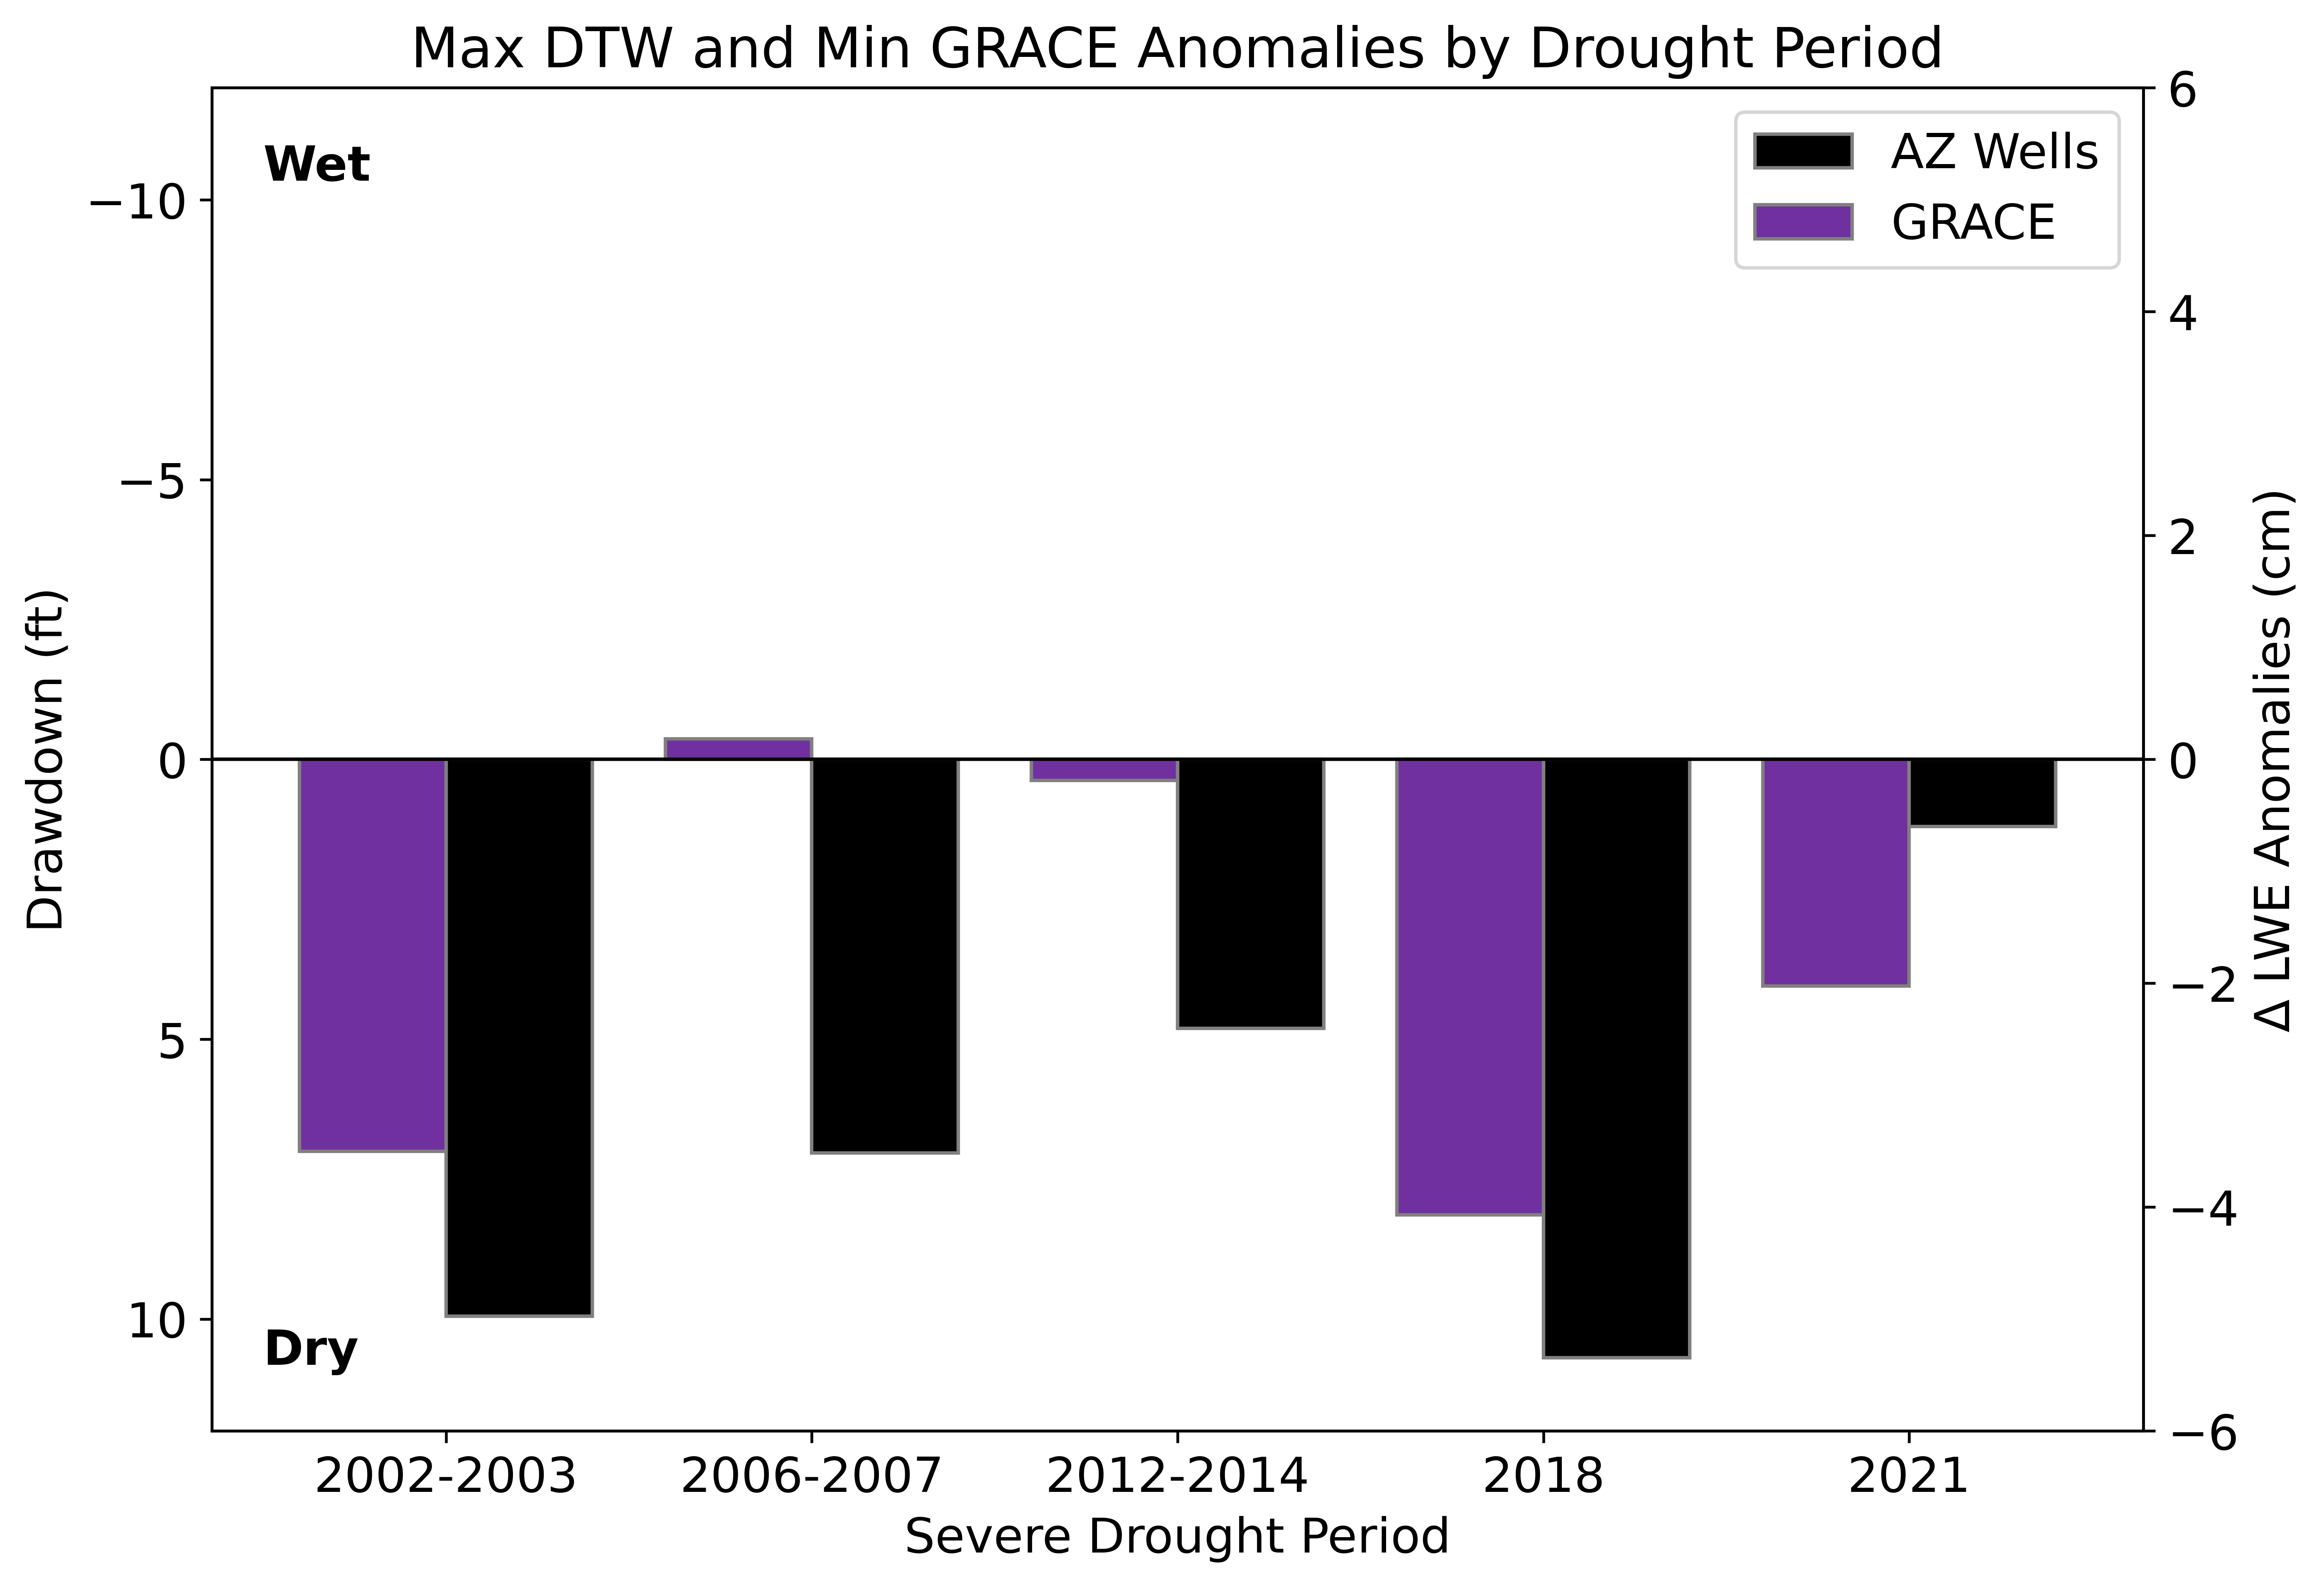

In [29]:
# Grouped Bar chart for drawdown (ft) / min GRACE anomaly
ds = lwe_drawdown_grace
ds2 = dtw_drawdown_wells
name = 'Max DTW and Min GRACE Anomalies by Drought Period'

group_colors = [grace_color, az_wells_color]  # Add another color for the second DataFrame

vertlabel1 = u'Δ LWE Anomalies (cm)'
vertlabel2 = 'Drawdown (ft)'
fsize = 14
well_ylimit = 12
grace_ylimit = 6

yearlabels = [
    # "1989-1990",
    # '1996',
    '2002-2003',
    '2006-2007',
    '2012-2014',
    '2018',
    '2021',
    'Normal/Wet Years'
]

ds.index = yearlabels
ds = ds.transpose()
ds.index = betterlabels
del ds['Normal/Wet Years']
ds = ds.transpose()

ds2.index = yearlabels
ds2 = ds2.transpose()
ds2.index = betterlabels2
del ds2['Normal/Wet Years']
ds2 = ds2.transpose()

plt.rcParams["figure.dpi"] = 600
fig, ax1 = plt.subplots(figsize=(10, 7))

# Bar width
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(len(ds))
r2 = [x + bar_width for x in r1]

# Plotting the first DataFrame on the left y-axis
ax1.bar(r2, ds2.iloc[:, 0], color=group_colors[1], width=bar_width, edgecolor='grey', label=ds2.columns[0])
ax1.set_ylabel(vertlabel2, fontsize=fsize)
ax1.set_ylim(well_ylimit,-well_ylimit)
ax1.tick_params(axis='y', labelsize=fsize)

# X-axis
ax1.set_xlabel('Severe Drought Period', fontsize=fsize)
ax1.set_xticks([r + bar_width / 2 for r in range(len(yearlabels))])
ax1.set_xticklabels(yearlabels, rotation=0, fontsize=fsize)

# Creating a twin Axes sharing the xaxis for the second DataFrame
ax2 = ax1.twinx()
ax2.bar(r1, ds.iloc[:, 0], color=group_colors[0], width=bar_width, edgecolor='grey', label=ds.columns[0])
ax2.set_ylabel(vertlabel1, fontsize=fsize)
ax2.set_ylim(-grace_ylimit,grace_ylimit)
ax2.tick_params(axis='y', labelsize=fsize)

# Zero line
plt.axhspan(0,0,color='black',lw=1)

# Adding a legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=fsize)

# Adding text inside the plot
ax1.text(-0.3, 1-well_ylimit, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax1.text(-0.3, well_ylimit-1, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

# Setting the title
plt.title(name, fontsize=fsize + 2)

# Show the plot
plt.show()

# plt.savefig(figurepath + name + '_groupedchart', bbox_inches='tight')
